In [920]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage.filters as filters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import os

In [921]:
def use_thresholds(y, low=0.05, high=0.95):
    new_y = y.copy()
    new_y[new_y < low] = 0
    new_y[new_y > high] = 1
    return new_y

In [922]:
def get_segments(y):
    result = []
    start = 0
    while start < len(y):
        if max(y[start:]) == 0:
            return result
        while not y[start]:
            start += 1
        finish = start
        while finish < len(y) and y[finish]:
            finish += 1
        result.append(y[start:finish])
        start = finish
    return result

In [923]:
def get_average_segment_length(segments):
    return sum([len(s) for s in segments]) / len(segments)

In [924]:
def get_increases(segments, min_len=3):
    ends = [get_increase_end(s) for s in segments]
    return [seg[:end] for seg, end in zip(segments, ends) if end >= min_len]

In [925]:
def get_decreases(segments, min_len=3):
    starts = [get_increase_end(s[::-1]) for s in segments]
    return [seg[::-1][:start][::-1] for seg, start in zip(segments, starts) if start >= min_len]

In [926]:
def get_increase_end(seg):
        finish = 0
        while finish + 1 < len(seg) and seg[finish] <= seg[finish + 1] and seg[finish] < 1:
            finish += 1
        return finish

In [927]:
def predict(forest, x, threshold=0.8):
    valid_y = forest.predict_proba(x)[:, 1]
    th = [sum(valid_y > t / 100) for t in range(50, 100)]
    valid_y = valid_y > threshold
    print(sum(valid_y))
    plt.plot(th, xdata=range(50, 100))
    return valid_y

In [928]:
def read_marks_dir(directory):
    f = []
    x = []
    e = []
    b = []
    d = []
    t = []
    m = []
    c = []
    z = []
    for fl in os.listdir(directory):
        if not fl.endswith(".npy"):
            continue
        mat = np.load(os.path.join(directory, fl))
        f.append(Y([q[0] for q in mat]).get_features())
        x.append(Y([q[1] for q in mat]).get_features())
        e.append(Y([q[2] for q in mat]).get_features())
        b.append(Y([q[3] for q in mat]).get_features())
        d.append(Y([q[4] for q in mat]).get_features())
        t.append(Y([q[5] for q in mat]).get_features())
        m.append(Y([q[6] for q in mat]).get_features())
        c.append(Y([q[7] for q in mat]).get_features())
        z.append(Y([q[8] for q in mat]).get_features())
    bridges = full_combo(m, t)
    bump = full_combo(b, f)
    zebra = full_combo(z, c)
    wipers = full_combo(d)
    enter = full_combo(e)
    exit = full_combo(x)
    return bridges, enter, exit, bump, wipers, zebra

In [937]:
def read_marks(filename):
    return [Y(i).get_features() for i in np.load(filename, encoding='bytes')]
    
def gen_train(*filenames):
    if len(filenames) == 1:
        return read_marks(filenames[0])
    return full_combo(*[read_marks(f) for f in filenames])

In [930]:
def full_combo(*trains):
    if len(trains) == 1:
        return trains[0]
    res = []
    for i in range(len(trains[0])):
        res.append(combine_trains(*[trains[j][i] for j in range(len(trains))]))
    return res

In [931]:
def combine_trains(*trains):
    if len(trains) == 1:
        return trains
    result = []
    for t in trains:
        appendix = []
        for r in result:
            if r.shape == t.shape:
                appendix.append(r * t)
        result += appendix + [t.copy()]
    return np.hstack(result)

In [932]:
class Y(object):
    def __init__(self, values, filter_size=3):
        self.values = values.copy()
        self.values = use_thresholds(filters.median_filter(self.values, filter_size))
        self.segments = get_segments(self.values)
        self.seg_len = [len(s) for s in self.segments]
        self.increases = get_increases(self.segments, 1)
        self.inc_len = [len(i) for i in self.increases]
        self.decreases = get_decreases(self.segments)
        self.dec_len = [len(i) for i in self.decreases]
        self.len_extractors = [
            len, 
            np.average, 
            np.min, 
            np.max,
            np.sum,
        ]
        self.len_extractors = [lambda x: e(x) / len(self.values) for e in self.len_extractors]
        
    def _get_features_from_collection(self, collection, extractors=None):
        if extractors is None:
            extractors = self.len_extractors
        if not len(collection):
            return [0] * len(extractors)
        return [e(collection) for e in extractors]
        
    def _get_features_from_values(self):
        return self._get_features_from_collection(self.values, (
            lambda x: np.min(list(x[x > 0]) + [0]), 
            np.max, 
            np.average, 
            lambda x: np.sum(x[x == 1]) / len(x),
        ))
    
    def _get_features_from_seg_len(self):
        return self._get_features_from_collection(self.seg_len)
    
    def _get_features_from_inc_len(self):
        return self._get_features_from_collection(self.inc_len)
    
    def _get_features_from_dec_len(self):
        return self._get_features_from_collection(self.dec_len)
    
    def get_features(self):
        return np.array((
            self._get_features_from_values()
            + self._get_features_from_seg_len()
            + self._get_features_from_inc_len()
            + self._get_features_from_dec_len()
        ) + list(self.values[:5]) + list(self.values[-5:]))

In [933]:
train_video_filenames = ['akn.022.008.left.avi', 'akn.031.029.left.avi', 'akn.031.037.left.avi', 'akn.078.031.left.avi', 'akn.082.013.left.avi', 'akn.082.021.left.avi', 'akn.083.014.left.avi', 'akn.083.044.left.avi', 'akn.084.048.left.avi', 'akn.088.141.left.avi', 'akn.090.144.left.avi', 'akn.098.056.left.avi', 'akn.113.165.left.avi', 'akn.119.217.left.avi', 'akn.119.266.left.avi', 'akn.131.066.left.avi', 'akn.131.068.left.avi', 'akn.131.123.left.avi', 'akn.136.026.left.avi', 'akn.136.122.left.avi', 'akn.144.212.left.avi', 'akn.159.018.left.avi', 'akn.160.025.left.avi', 'akn.160.032.left.avi', 'akn.160.036.left.avi', 'akn.160.225.left.avi', 'akn.163.014.left.avi', 'akn.163.175.left.avi', 'akn.165.120.left.avi', 'akn.166.144.left.avi', 'akn.174.010.left.avi', 'akn.174.030.left.avi', 'akn.174.056.left.avi', 'akn.174.083.left.avi', 'akn.174.086.left.avi', 'akn.174.090.left.avi', 'akn.174.096.left.avi', 'akn.174.100.left.avi', 'akn.174.106.left.avi', 'akn.174.124.left.avi', 'akn.176.016.left.avi', 'akn.176.125.left.avi', 'akn.176.216.left.avi', 'akn.178.079.left.avi', 'akn.179.031.left.avi', 'akn.179.087.left.avi', 'akn.179.092.left.avi', 'akn.179.178.left.avi', 'akn.182.020.left.avi', 'akn.182.029.left.avi', 'akn.182.050.left.avi', 'akn.182.130.left.avi', 'akn.184.139.left.avi', 'akn.185.061.left.avi', 'akn.185.084.left.avi', 'akn.186.020.left.avi', 'akn.186.105.left.avi', 'akn.186.156.left.avi', 'akn.187.023.left.avi', 'akn.188.262.left.avi', 'akn.189.239.left.avi', 'akn.189.241.left.avi', 'akn.190.381.left.avi', 'akn.190.410.left.avi', 'akn.193.073.left.avi', 'akn.197.093.left.avi', 'akn.198.136.left.avi', 'akn.199.020.left.avi', 'akn.200.010.left.avi', 'akn.204.006.left.avi', 'akn.211.002.left.avi', 'akn.211.006.left.avi', 'akn.212.018.left.avi', 'akn.212.100.left.avi', 'akn.212.134.left.avi', 'akn.212.179.left.avi', 'akn.212.221.left.avi', 'akn.212.237.left.avi', 'akn.215.153.left.avi', 'akn.215.175.left.avi', 'akn.216.133.left.avi', 'akn.217.019.left.avi', 'akn.217.104.left.avi', 'akn.219.014.left.avi', 'akn.219.149.left.avi', 'akn.219.183.left.avi', 'akn.220.011.left.avi', 'akn.220.030.left.avi', 'akn.220.132.left.avi', 'akn.221.004.left.avi', 'akn.222.007.left.avi', 'akn.222.029.left.avi', 'akn.223.098.left.avi', 'akn.224.017.left.avi', 'akn.224.115.left.avi', 'akn.228.171.left.avi', 'akn.228.225.left.avi', 'akn.228.244.left.avi', 'akn.229.188.left.avi', 'akn.232.051.left.avi', 'akn.232.074.left.avi', 'akn.232.162.left.avi', 'akn.233.113.left.avi', 'akn.233.148.left.avi', 'akn.233.152.left.avi', 'akn.233.182.left.avi', 'akn.240.027.left.avi', 'akn.240.095.left.avi', 'akn.240.184.left.avi', 'akn.243.043.left.avi', 'akn.243.177.left.avi', 'akn.243.206.left.avi', 'akn.243.207.left.avi', 'akn.243.211.left.avi', 'akn.244.049.left.avi', 'akn.244.141.left.avi', 'akn.244.165.left.avi', 'akn.245.022.left.avi', 'akn.247.011.left.avi', 'akn.250.022.left.avi', 'akn.250.140.left.avi', 'akn.250.300.left.avi', 'akn.251.029.left.avi', 'akn.256.049.left.avi', 'akn.261.088.left.avi', 'akn.263.136.left.avi', 'akn.266.024.left.avi', 'akn.266.396.left.avi', 'akn.266.430.left.avi', 'akn.267.004.left.avi', 'akn.267.064.left.avi', 'akn.267.135.left.avi', 'akn.267.139.left.avi', 'akn.269.036.left.avi', 'akn.269.085.left.avi', 'akn.269.094.left.avi', 'akn.269.111.left.avi', 'akn.270.197.left.avi', 'akn.271.109.left.avi', 'akn.271.132.left.avi', 'akn.272.018.left.avi', 'akn.272.139.left.avi', 'akn.273.009.left.avi', 'akn.273.014.left.avi', 'akn.273.056.left.avi', 'akn.273.074.left.avi', 'akn.275.015.left.avi', 'akn.275.115.left.avi', 'akn.279.026.left.avi', 'akn.280.006.left.avi', 'akn.281.024.left.avi', 'akn.281.131.left.avi', 'akn.282.083.left.avi', 'akn.283.065.left.avi', 'akn.283.175.left.avi', 'akn.283.209.left.avi', 'akn.289.008.left.avi', 'akn.289.041.left.avi', 'akn.289.048.left.avi', 'akn.289.057.left.avi', 'akn.289.058.left.avi', 'akn.289.069.left.avi', 'akn.292.005.left.avi', 'akn.292.154.left.avi', 'akn.294.156.left.avi', 'akn.295.027.left.avi', 'akn.295.194.left.avi', 'akn.308.081.left.avi', 'akn.308.104.left.avi', 'akn.308.139.left.avi', 'akn.343.073.left.avi', 'akn.343.399.left.avi', 'akn.344.034.left.avi', 'akn.344.050.left.avi', 'akn.344.106.left.avi', 'akn.345.006.left.avi', 'akn.345.202.left.avi', 'akn.389.266.left.avi', 'akn.389.282.left.avi', 'akn.391.181.left.avi', 'akn.391.241.left.avi', 'akn.393.054.left.avi', 'akn.393.224.left.avi', 'akn.393.331.left.avi', 'akn.394.008.left.avi', 'akn.394.018.left.avi', 'akn.394.123.left.avi', 'akn.395.047.left.avi', 'akn.414.251.left.avi', 'akn.419.002.left.avi', 'akn.420.236.left.avi', 'akn.421.209.left.avi', 'akn.421.241.left.avi', 'akn.421.252.left.avi', 'akn.421.255.left.avi', 'akn.421.412.left.avi', 'akn.425.073.left.avi', 'akn.429.105.left.avi', 'akn.430.500.left.avi', 'akn.431.139.left.avi']
valid_video_filenames = ['akn.031.008.left.avi', 'akn.031.041.left.avi', 'akn.048.067.left.avi', 'akn.078.047.left.avi', 'akn.079.064.left.avi', 'akn.081.021.left.avi', 'akn.081.054.left.avi', 'akn.082.001.left.avi', 'akn.084.020.left.avi', 'akn.090.121.left.avi', 'akn.112.004.left.avi', 'akn.113.142.left.avi', 'akn.131.019.left.avi', 'akn.132.075.left.avi', 'akn.136.038.left.avi', 'akn.136.059.left.avi', 'akn.136.213.left.avi', 'akn.136.274.left.avi', 'akn.139.044.left.avi', 'akn.145.038.left.avi', 'akn.145.141.left.avi', 'akn.151.155.left.avi', 'akn.152.144.left.avi', 'akn.160.015.left.avi', 'akn.160.030.left.avi', 'akn.160.215.left.avi', 'akn.160.227.left.avi', 'akn.160.230.left.avi', 'akn.160.370.left.avi', 'akn.160.379.left.avi', 'akn.165.068.left.avi', 'akn.166.049.left.avi', 'akn.174.089.left.avi', 'akn.174.093.left.avi', 'akn.174.094.left.avi', 'akn.174.097.left.avi', 'akn.174.103.left.avi', 'akn.174.119.left.avi', 'akn.174.140.left.avi', 'akn.174.149.left.avi', 'akn.176.054.left.avi', 'akn.176.148.left.avi', 'akn.176.171.left.avi', 'akn.178.106.left.avi', 'akn.178.218.left.avi', 'akn.179.103.left.avi', 'akn.182.002.left.avi', 'akn.182.004.left.avi', 'akn.182.062.left.avi', 'akn.182.108.left.avi', 'akn.182.138.left.avi', 'akn.183.042.left.avi', 'akn.184.002.left.avi', 'akn.184.071.left.avi', 'akn.184.109.left.avi', 'akn.184.110.left.avi', 'akn.184.150.left.avi', 'akn.185.062.left.avi', 'akn.185.070.left.avi', 'akn.185.171.left.avi', 'akn.186.054.left.avi', 'akn.186.063.left.avi', 'akn.186.064.left.avi', 'akn.186.178.left.avi', 'akn.187.029.left.avi', 'akn.187.170.left.avi', 'akn.189.245.left.avi', 'akn.189.249.left.avi', 'akn.190.394.left.avi', 'akn.192.107.left.avi', 'akn.192.122.left.avi', 'akn.195.097.left.avi', 'akn.196.065.left.avi', 'akn.199.016.left.avi', 'akn.207.058.left.avi', 'akn.211.008.left.avi', 'akn.211.011.left.avi', 'akn.212.238.left.avi', 'akn.213.002.left.avi', 'akn.213.022.left.avi', 'akn.213.052.left.avi', 'akn.213.357.left.avi', 'akn.214.036.left.avi', 'akn.215.131.left.avi', 'akn.215.159.left.avi', 'akn.215.162.left.avi', 'akn.215.174.left.avi', 'akn.217.155.left.avi', 'akn.219.035.left.avi', 'akn.220.009.left.avi', 'akn.220.010.left.avi', 'akn.220.031.left.avi', 'akn.222.004.left.avi', 'akn.223.010.left.avi', 'akn.223.015.left.avi', 'akn.223.019.left.avi', 'akn.223.057.left.avi', 'akn.223.214.left.avi', 'akn.224.016.left.avi', 'akn.224.030.left.avi', 'akn.224.040.left.avi', 'akn.226.001.left.avi', 'akn.226.080.left.avi', 'akn.226.130.left.avi', 'akn.228.125.left.avi', 'akn.229.086.left.avi', 'akn.229.170.left.avi', 'akn.232.047.left.avi', 'akn.232.050.left.avi', 'akn.233.017.left.avi', 'akn.233.260.left.avi', 'akn.240.107.left.avi', 'akn.240.123.left.avi', 'akn.241.044.left.avi', 'akn.241.109.left.avi', 'akn.241.130.left.avi', 'akn.241.131.left.avi', 'akn.243.162.left.avi', 'akn.243.231.left.avi', 'akn.244.272.left.avi', 'akn.245.047.left.avi', 'akn.246.009.left.avi', 'akn.246.061.left.avi', 'akn.249.032.left.avi', 'akn.250.230.left.avi', 'akn.250.265.left.avi', 'akn.256.117.left.avi', 'akn.256.137.left.avi', 'akn.261.008.left.avi', 'akn.263.023.left.avi', 'akn.266.392.left.avi', 'akn.267.150.left.avi', 'akn.268.054.left.avi', 'akn.268.082.left.avi', 'akn.269.082.left.avi', 'akn.269.097.left.avi', 'akn.269.115.left.avi', 'akn.273.044.left.avi', 'akn.273.086.left.avi', 'akn.275.009.left.avi', 'akn.275.013.left.avi', 'akn.275.072.left.avi', 'akn.275.080.left.avi', 'akn.276.214.left.avi', 'akn.276.240.left.avi', 'akn.276.246.left.avi', 'akn.277.119.left.avi', 'akn.278.125.left.avi', 'akn.279.014.left.avi', 'akn.279.020.left.avi', 'akn.279.027.left.avi', 'akn.279.032.left.avi', 'akn.279.044.left.avi', 'akn.279.235.left.avi', 'akn.282.018.left.avi', 'akn.282.069.left.avi', 'akn.283.210.left.avi', 'akn.289.007.left.avi', 'akn.289.046.left.avi', 'akn.289.047.left.avi', 'akn.289.055.left.avi', 'akn.289.063.left.avi', 'akn.289.068.left.avi', 'akn.289.109.left.avi', 'akn.292.002.left.avi', 'akn.295.193.left.avi', 'akn.308.095.left.avi', 'akn.343.101.left.avi', 'akn.344.029.left.avi', 'akn.344.046.left.avi', 'akn.344.074.left.avi', 'akn.344.090.left.avi', 'akn.345.037.left.avi', 'akn.345.074.left.avi', 'akn.345.215.left.avi', 'akn.346.244.left.avi', 'akn.389.020.left.avi', 'akn.389.270.left.avi', 'akn.390.126.left.avi', 'akn.391.185.left.avi', 'akn.391.411.left.avi', 'akn.391.417.left.avi', 'akn.391.422.left.avi', 'akn.393.029.left.avi', 'akn.393.202.left.avi', 'akn.393.243.left.avi', 'akn.393.269.left.avi', 'akn.393.334.left.avi', 'akn.394.005.left.avi', 'akn.394.111.left.avi', 'akn.394.115.left.avi', 'akn.394.163.left.avi', 'akn.394.210.left.avi', 'akn.394.216.left.avi', 'akn.398.102.left.avi', 'akn.419.006.left.avi', 'akn.419.022.left.avi', 'akn.421.450.left.avi', 'akn.425.139.left.avi', 'akn.430.048.left.avi']
with open("../trainset/train.txt") as fin:
    ans = {name: [int(i) for i in value] for name, value in [line.split() for line in fin.readlines()]}
train_y_bridge = [ans[name][0] for name in train_video_filenames]
train_y_enter = [ans[name][1] for name in train_video_filenames]
train_y_exit = [ans[name][2] for name in train_video_filenames]
train_y_bump = [ans[name][3] for name in train_video_filenames]
train_y_wipers = [ans[name][4] for name in train_video_filenames]
train_y_zebra = [ans[name][5] for name in train_video_filenames]

In [980]:
train_x_bridge = gen_train("bridge.npy", "under_bridge_train.npy")
train_x_zebra = gen_train("sign_zebra_train.npy")
train_x_bump = gen_train("bump_sign_train.npy")
train_x_wipers = gen_train("wipers_train.npy")
train_x_enter = gen_train("enter_train.npy")
train_x_exit = gen_train("enter_train.npy")
# train_x_bridge, train_x_enter, train_x_exit, train_x_bump, train_x_wipers, train_x_zebra = read_marks_dir("../full_train/")

In [981]:
valid_x_bridge = gen_train("validation_bridge.npy", "under_bridge_valid.npy")
valid_x_zebra = gen_train("sign_zebra_valid.npy")
valid_x_bump = gen_train("bump_sign_valid.npy")
valid_x_wipers = gen_train("wipers_valid.npy")
valid_x_enter = gen_train("enter_valid.npy")
valid_x_exit = gen_train("enter_valid.npy")
# valid_x_bridge, valid_x_enter, valid_x_exit, valid_x_bump, valid_x_wipers, valid_x_zebra = read_marks_dir("../full_valid/")

In [982]:
with open("../validationset/valid.txt") as fin:
    ans = {name: [int(i) for i in value] for name, value in [line.split() for line in fin.readlines()]}
ans_y_bridge = np.array([ans[name][0] for name in valid_video_filenames])
ans_y_enter = np.array([ans[name][1] for name in valid_video_filenames])
ans_y_exit = np.array([ans[name][2] for name in valid_video_filenames])
ans_y_bump = np.array([ans[name][3] for name in valid_video_filenames])
ans_y_wipers = np.array([ans[name][4] for name in valid_video_filenames])
ans_y_zebra = np.array([ans[name][5] for name in valid_video_filenames])

In [983]:
# train_x_bridge, valid_x_bridge, train_y_bridge, ans_y_bridge = train_test_split(valid_x_bridge, ans_y_bridge, test_size=0.4)
# train_x_bump, valid_x_bump, train_y_bump, ans_y_bump = train_test_split(valid_x_bump, ans_y_bump, test_size=0.4)

In [984]:
def measure(valid, ans):
    TP = np.sum(valid[valid == ans] == 1)
    FP = np.sum(valid[valid != ans] == 1)
    return TP * 100 / np.sum(ans) - FP * 1000 / (len(ans) - np.sum(ans))

In [985]:
def create_forest(x_train, y_train):
    forest = RandomForestClassifier(n_estimators=1000, random_state=123)
    forest.fit(x_train, y_train)
    return forest

In [986]:
bridge_forest = create_forest(train_x_bridge, train_y_bridge)
enter_forest = create_forest(train_x_enter, train_y_enter)
exit_forest = create_forest(train_x_exit, train_y_exit)
bump_forest = create_forest(train_x_bump, train_y_bump)
wipers_forest = create_forest(train_x_wipers, train_y_wipers)
zebra_forest = create_forest(train_x_zebra, train_y_zebra)

55


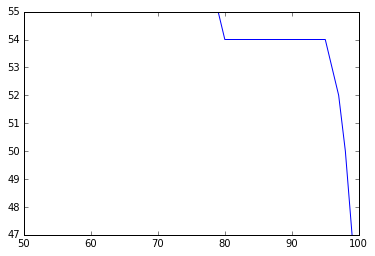

In [987]:
valid_y_bridge = predict(bridge_forest, valid_x_bridge, 0.7)

0


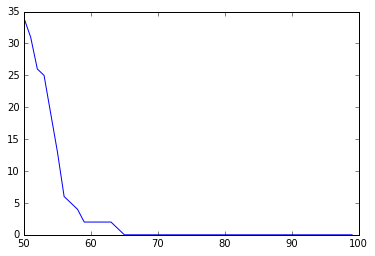

In [998]:
valid_y_zebra = predict(zebra_forest, valid_x_zebra, 0.7)

17


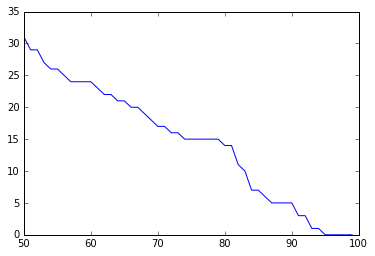

In [989]:
valid_y_bump = predict(bump_forest, valid_x_bump, 0.7)

31


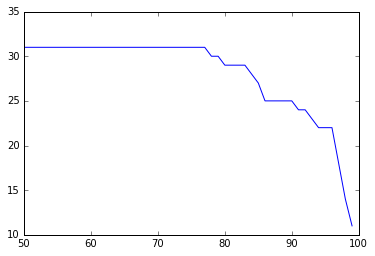

In [990]:
valid_y_wipers = predict(wipers_forest, valid_x_wipers, 0.7)

0


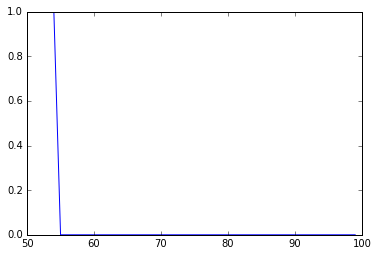

In [991]:
valid_y_enter = predict(enter_forest, valid_x_enter, 0.7)

0


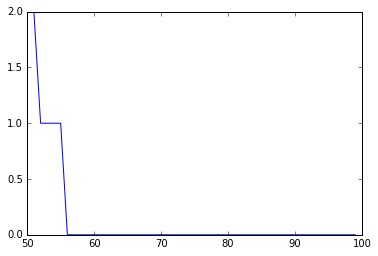

In [992]:
valid_y_exit = predict(exit_forest, valid_x_exit, 0.7)

In [999]:
t = measure(valid_y_bridge, ans_y_bridge)
z = measure(valid_y_zebra, ans_y_zebra)
b = measure(valid_y_bump, ans_y_bump)
w = measure(valid_y_wipers, ans_y_wipers)
e = measure(valid_y_enter, ans_y_enter)
x = measure(valid_y_exit, ans_y_exit)

print("Bridges:", t)
print("Enter:", e)
print("Exit:", x)
print("Bumps:", b)
print("Wipers:", w)
print("Zebras:", z)
print("Score:", b + z + t + w + e + x)

Bridges: 89.4841269841
Enter: 0.0
Exit: 0.0
Bumps: 26.0391782131
Wipers: 82.5581395349
Zebras: 0.0
Score: 198.081444732


In [896]:
with open("validation_y.txt", "w") as fout:
    for name, t, e, x, b, w, z in zip(
        valid_video_filenames, 
        valid_y_bridge,
        valid_y_enter,
        valid_y_exit,
        valid_y_bump, 
        valid_y_wipers, 
        valid_y_zebra,
    ):
        fout.write("{} {}{}{}{}{}{}\n".format(name, int(t), int(e), int(x), int(b), int(w), int(z)))